## Importing Libraries


In [72]:
#supress warnings
import warnings
warnings.filterwarnings('ignore')

#numpy and pandas for data manipulation
import pandas as pd
import numpy as np
import xgboost as xg
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#matplotlib and seaborn for data visualization
import matplotlib.pyplot as plt

#file system management
import os

## Reading the dataset


In [73]:
df = pd.read_csv('./data/monatszahlen2209_verkehrsunfaelle.csv')
df.head()

,MONATSZAHL,AUSPRÄGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERÄND_VORMONAT_PROZENT,VERÄND_VORJAHRESMONAT_PROZENT,ZWÖLF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2022,202201,NaN,16.0,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2022,202202,NaN,14.0,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2022,202203,NaN,24.0,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2022,202204,NaN,16.0,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2022,202205,NaN,24.0,NaN,NaN,NaN


In [74]:
df.isnull().sum()

MONATSZAHL                         0
AUSPRÄGUNG                         0
JAHR                               0
MONAT                              0
WERT                              84
VORJAHRESWERT                     91
VERÄND_VORMONAT_PROZENT          246
VERÄND_VORJAHRESMONAT_PROZENT    176
ZWÖLF_MONATE_MITTELWERT          238
dtype: int64

## Preprocessing the dataset


In [75]:
# As mentioned, only first 5 columns are important
df = df.iloc[:,:5]
df.head()

,MONATSZAHL,AUSPRÄGUNG,JAHR,MONAT,WERT
0,Alkoholunfälle,insgesamt,2022,202201,NaN
1,Alkoholunfälle,insgesamt,2022,202202,NaN
2,Alkoholunfälle,insgesamt,2022,202203,NaN
3,Alkoholunfälle,insgesamt,2022,202204,NaN
4,Alkoholunfälle,insgesamt,2022,202205,NaN


In [76]:
# Dropping data that comes after 2020
df = df[(df.JAHR <= 2020) ]
df.head()

,MONATSZAHL,AUSPRÄGUNG,JAHR,MONAT,WERT
25,Alkoholunfälle,insgesamt,2020,Summe,430.0
26,Alkoholunfälle,insgesamt,2020,202001,28.0
27,Alkoholunfälle,insgesamt,2020,202002,40.0
28,Alkoholunfälle,insgesamt,2020,202003,27.0
29,Alkoholunfälle,insgesamt,2020,202004,26.0


## Exploratory Data Analysis

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1911 entries, 25 to 2085
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MONATSZAHL  1911 non-null   object 
 1   AUSPRÄGUNG  1911 non-null   object 
 2   JAHR        1911 non-null   int64  
 3   MONAT       1911 non-null   object 
 4   WERT        1911 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 89.6+ KB


In [78]:
# percentage of data which is null in each column
(df.isna().sum() / df.shape[0]) * 100

MONATSZAHL    0.0
AUSPRÄGUNG    0.0
JAHR          0.0
MONAT         0.0
WERT          0.0
dtype: float64

In [79]:
df["WERT"].describe()

count     1911.000000
mean      1440.540031
std       4655.514611
min          0.000000
25%         41.000000
50%        399.000000
75%        864.000000
max      46988.000000
Name: WERT, dtype: float64

In [80]:
df["MONAT"].describe()

count      1911
unique      253
top       Summe
freq        147
Name: MONAT, dtype: object

In [81]:
df["JAHR"].describe()

count    1911.000000
mean     2010.000000
std         6.056886
min      2000.000000
25%      2005.000000
50%      2010.000000
75%      2015.000000
max      2020.000000
Name: JAHR, dtype: float64

In [82]:
df["AUSPRÄGUNG"].unique()

array(['insgesamt', 'Verletzte und Getötete', 'mit Personenschäden'],
      dtype=object)

In [83]:
df["MONATSZAHL"].unique()

array(['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle'], dtype=object)

In [84]:
# Creating new_df for statistical analysis
new_df = df[['MONAT','WERT']]
new_df.head()

,MONAT,WERT
25,Summe,430.0
26,202001,28.0
27,202002,40.0
28,202003,27.0
29,202004,26.0


In [85]:
new_df = new_df.reset_index(drop=True)

In [86]:
new_df.head()

,MONAT,WERT
0,Summe,430.0
1,202001,28.0
2,202002,40.0
3,202003,27.0
4,202004,26.0


## EXploratory data analysis


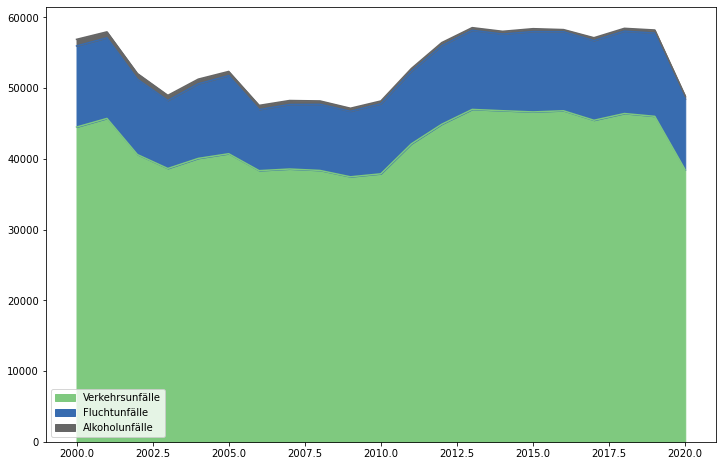

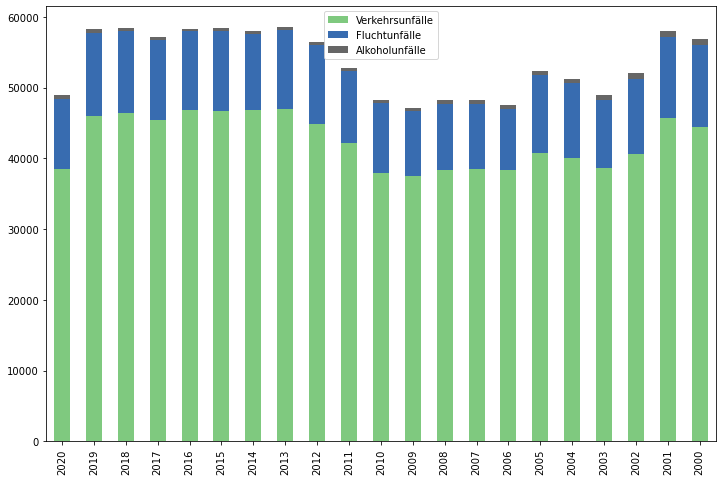

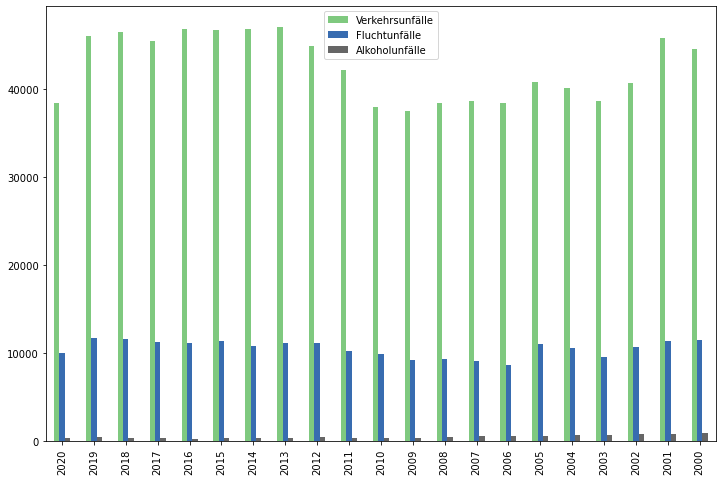

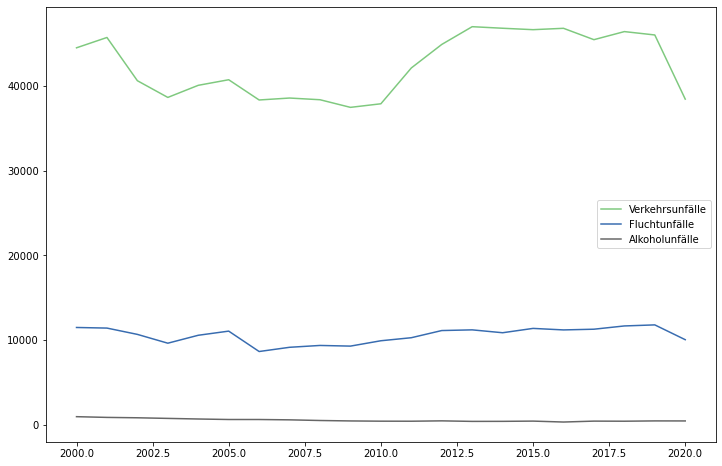

In [87]:
# Data Visualization

accidents = df[df['JAHR'] < 2021]

Verkehrsunfälle = accidents[(
    (accidents['MONATSZAHL'] == 'Verkehrsunfälle') &
    (accidents['MONAT'] == 'Summe') &
    (accidents['AUSPRÄGUNG'] == 'insgesamt')
)]
Fluchtunfälle = accidents[(
    (accidents['MONATSZAHL'] == 'Fluchtunfälle') &
    (accidents['MONAT'] == 'Summe') &
    (accidents['AUSPRÄGUNG'] == 'insgesamt')
)]
Alkoholunfälle = accidents[(
    (accidents['MONATSZAHL'] == 'Alkoholunfälle') &
    (accidents['MONAT'] == 'Summe') &
    (accidents['AUSPRÄGUNG'] == 'insgesamt')
)]
years = [i for i in range(2000, 2021)]
years.sort(reverse=True)

accidents_category = pd.DataFrame({
    "Verkehrsunfälle": Verkehrsunfälle['WERT'].to_numpy(),
    "Fluchtunfälle": Fluchtunfälle['WERT'].to_numpy(),
    "Alkoholunfälle": Alkoholunfälle['WERT'].to_numpy()
},
    index=years
)

accidents_category.plot(kind='area', colormap='Accent')
plt.gcf().set_size_inches(12, 8)
accidents_category.plot(kind='bar', colormap='Accent', stacked=True)
plt.gcf().set_size_inches(12, 8)
accidents_category.plot(kind='bar', colormap='Accent')
plt.gcf().set_size_inches(12, 8)
accidents_category.plot(colormap='Accent')
plt.gcf().set_size_inches(12, 8)


In [88]:
# Monat has only 147 summe so removing them
lst = ['Summe']
df = df[df.MONAT.isin(lst) == False]

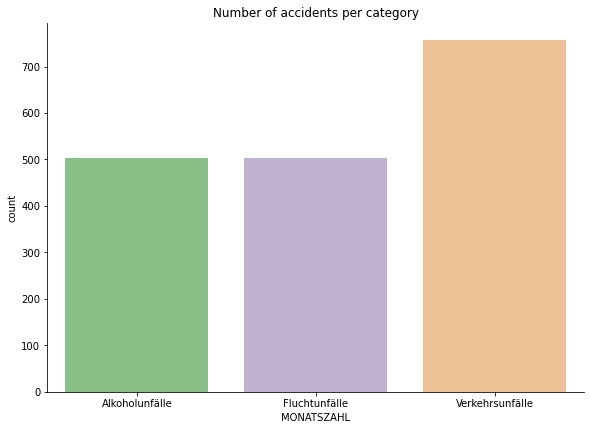

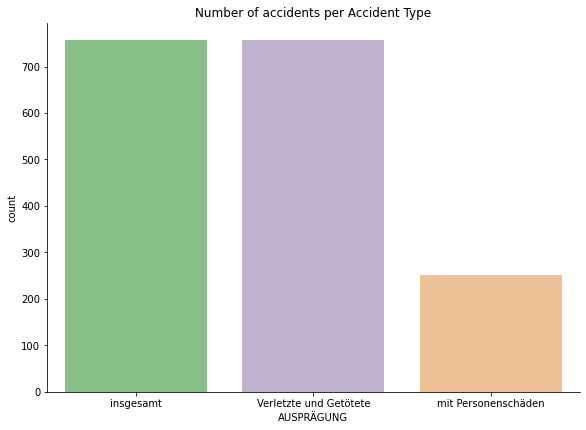

In [89]:
# Plot Number of accidents per category
plot = sns.catplot(x="MONATSZAHL", kind="count", data=df, palette="Accent")
plt.title('Number of accidents per category')
plt.gcf().set_size_inches(9,6)

# Plot Number of accidents per Accident Type
plot = sns.catplot(x="AUSPRÄGUNG", kind="count", data=df, palette="Accent")
plt.title('Number of accidents per Accident Type')
plt.gcf().set_size_inches(9,6)

In [90]:
df.tail()

,MONATSZAHL,AUSPRÄGUNG,JAHR,MONAT,WERT
2081,Verkehrsunfälle,Verletzte und Getötete,2000,200008,647.0
2082,Verkehrsunfälle,Verletzte und Getötete,2000,200009,675.0
2083,Verkehrsunfälle,Verletzte und Getötete,2000,200010,615.0
2084,Verkehrsunfälle,Verletzte und Getötete,2000,200011,578.0
2085,Verkehrsunfälle,Verletzte und Getötete,2000,200012,515.0


Here, we can see the different plots of no. of accidents that happened in various categories over the last 20 years.